In [53]:
import pandas as pd
from sklearn import preprocessing
from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import numpy as np
from xgboost import XGBClassifier
import warnings
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import log_loss, make_scorer
import csv
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,roc_auc_score,recall_score,precision_score,accuracy_score,f1_score
from sklearn.preprocessing import label_binarize
import statsmodels.api as sm
from itertools import cycle
from sklearn.metrics import confusion_matrix,roc_auc_score,recall_score,precision_score,accuracy_score,f1_score,roc_curve,auc
warnings.filterwarnings("ignore")



In [10]:
df_app_event = pd.read_csv('app_events.csv',dtype={'event_id': np.str, 'app_id': np.str, 'is_active':np.int64,'is_installed':np.int64})
df_mobile_brand = pd.read_csv('train_mobile_brand.csv',dtype={'device_id': np.str})
df_app_metadata = pd.read_csv('app_events_meta_data.csv',encoding='utf-8',quoting=csv.QUOTE_NONE)


In [18]:
df_events.head()

,Unnamed: 0,device_id,gender,age,group_train
0,1215595,398514470209561000,M,68,M32+
1,1215596,-3073918292047050000,M,27,M25-32
2,1215597,5805880616488060000,M,39,M32+
3,1215598,-2403560729305410000,M,25,M25-32
4,1215599,-1889893391998300000,M,22,M0-24


In [19]:
df_events = pd.read_csv('train_without_event.csv',dtype={'device_id': np.str})

In [20]:
df_events.drop(['Unnamed: 0','event_id','datetimestamp','latitude','longitude','event_day'],axis=1,inplace=True)

###  Create the Age Group as Label for output

In [21]:
# Define the age groups
bins = [0, 24, 32, 45, 150]
labels = ['0-24', '25-32', '33-45', '46+']

# Categorize the ages into groups
df_events['age_group'] = pd.cut(df_events['age'], bins=bins, labels=labels, right=False)

In [15]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51335 entries, 0 to 51334
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Unnamed: 0   51335 non-null  int64   
 1   device_id    51335 non-null  int64   
 2   gender       51335 non-null  object  
 3   age          51335 non-null  int64   
 4   group_train  51335 non-null  object  
 5   age_group    51335 non-null  category
dtypes: category(1), int64(3), object(2)
memory usage: 2.0+ MB


In [12]:
top_brand = ['samsung','Xiaomi','Huawei','Coolpad','OPPO','lenovo','vivo','Meizu','Gionee']
df_mobile_brand['phone_brand'] = df_mobile_brand['phone_brand'].apply(lambda x : x if  x in top_brand else 'other')

In [22]:
df_events = df_events.merge(df_mobile_brand[['device_id','phone_brand']], on='device_id',how='inner')


In [24]:
df_events.drop(['age'],axis=1,inplace=True)

In [27]:
df_encoded = pd.get_dummies(df_events, columns=['phone_brand'])


### Split the Dataset in Train  and Test split

In [29]:
train_test_data = pd.read_csv('train_test_split.csv',dtype={'device_id': np.str})

In [30]:
df_encoded = df_encoded.merge(train_test_data[['device_id','train_test_flag']], on='device_id')


In [31]:
train_data = df_encoded[df_encoded['train_test_flag'] == 'train']
test_data = df_encoded[df_encoded['train_test_flag'] == 'test']

In [32]:
train_data.shape

(41158, 15)

In [33]:
test_data.shape

(10280, 15)

### Train data and test data split in target and features

In [34]:
def age_group(age):
    if age == '0-24':
        return 0
    elif age == '25-32':
        return 1
    elif age == '33-45':
        return 2
    else:
        return 3

In [35]:
train_data['age_group'] = train_data['age_group'].apply(lambda x : age_group(x) )
test_data['age_group'] = test_data['age_group'].apply(lambda x: age_group(x))
train_data['gender'] = train_data['gender'].apply(lambda x: 0 if x == 'M' else 1)
test_data['gender'] = test_data['gender'].apply(lambda x: 0 if x=='M' else 1)

In [46]:
age_train = train_data['age_group'].values
gender_train = train_data['gender'].values
age_test = test_data['age_group'].values
gender_test = test_data['gender'].values
X_train = train_data.drop(['group_train','device_id','gender','train_test_flag','age_group'],axis = 1)
X_test = test_data.drop(['group_train','device_id','gender','train_test_flag','age_group'],axis = 1)

### Gender Prediction Modeling 

In [44]:
X_train.head()

,phone_brand_Coolpad,phone_brand_Gionee,phone_brand_Huawei,phone_brand_Meizu,phone_brand_OPPO,phone_brand_Xiaomi,phone_brand_lenovo,phone_brand_other,phone_brand_samsung,phone_brand_vivo
0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0


### 1. LogisticRegression (Started with simple model)

LogisticRegression on Test data 
0.5824902723735409
[[4374 2165]
 [2127 1614]]
Recall 0.4314354450681636
F1-Score 0.42925531914893617
Preicsion 0.42709711563905794


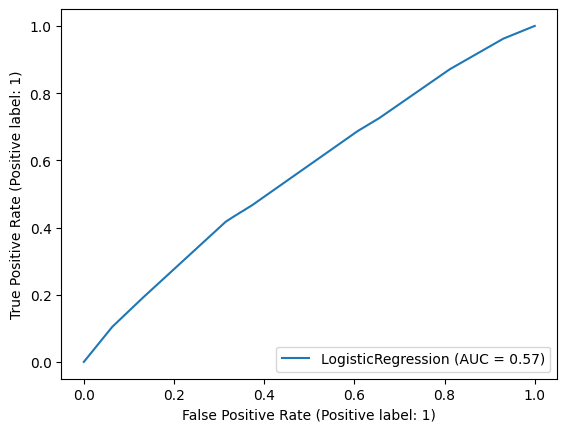

LogisticRegression on Training  data 
0.5795957043588124
[[17349  8816]
 [ 8487  6506]]
Recall 0.4339358367238044
F1-Score 0.42922645555005773
Preicsion 0.42461819605795587


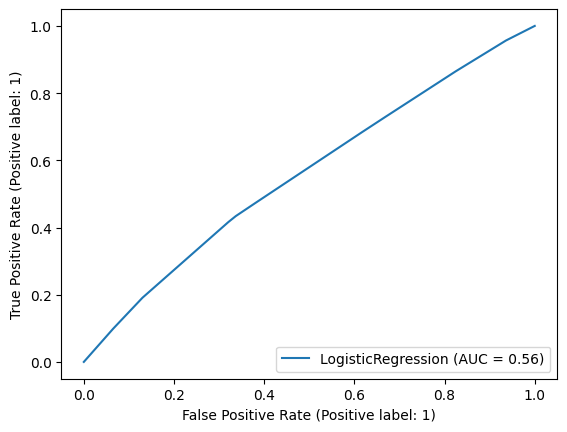

In [47]:
# diclare the logistic model
model = LogisticRegression(class_weight= 'balanced')
# train the model on the data
model.fit(X_train, gender_train)
y_pred = model.predict(X_test)
print("LogisticRegression on Test data ")
print(accuracy_score(gender_test, y_pred))
# Plot and print confusion matrix
cnf_matrix = confusion_matrix(gender_test, y_pred)
print(cnf_matrix)
print('Recall',recall_score(gender_test, y_pred))
print('F1-Score',f1_score(gender_test, y_pred))
print('Preicsion',precision_score(gender_test, y_pred))
roc_auc_score(gender_test, model.predict_proba(X_test)[:, 1])
RocCurveDisplay.from_estimator(model, X_test, gender_test) 
plt.show()

print("LogisticRegression on Training  data ")
y_pred = model.predict(X_train)

print(accuracy_score(gender_train, y_pred))
# Plot and print confusion matrix
cnf_matrix = confusion_matrix(gender_train, y_pred)
print(cnf_matrix)
print('Recall',recall_score(gender_train, y_pred))
print('F1-Score',f1_score(gender_train, y_pred))
print('Preicsion',precision_score(gender_train, y_pred))
roc_auc_score(gender_train, model.predict_proba(X_train)[:, 1])
RocCurveDisplay.from_estimator(model, X_train, gender_train) 
plt.show()

### Trying boosting alg

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBClassifier on Test Dataset


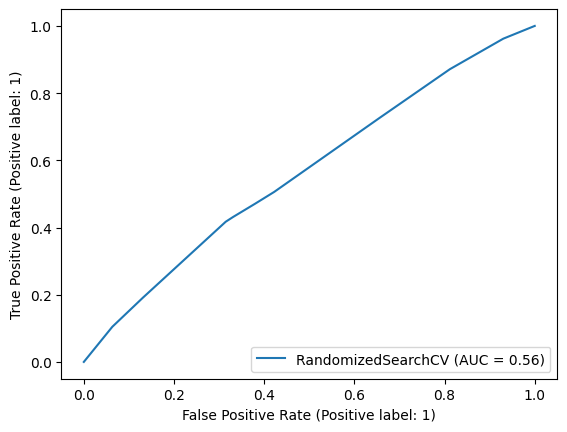

XGBClassifier on Train Dataset


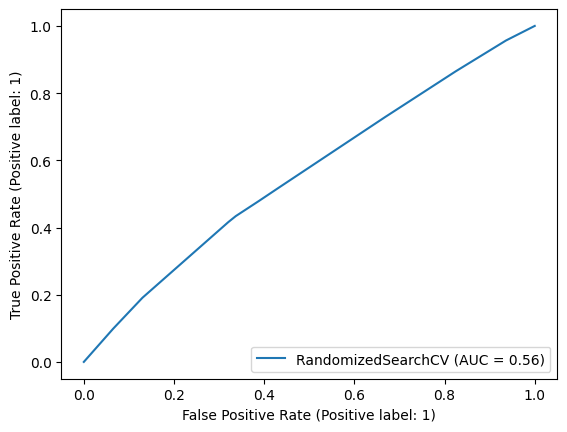

In [49]:
x_cfl=XGBClassifier(verbosity=0)
n_folds = 5
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
random_cfl=RandomizedSearchCV(x_cfl,prams,verbose=1,n_jobs=-1,return_train_score=True,scoring=LogLoss)
random_cfl.fit(X_train,gender_train)
print("XGBClassifier on Test Dataset")

roc_auc_score(gender_test, random_cfl.predict_proba(X_test)[:, 1])
RocCurveDisplay.from_estimator(random_cfl, X_test, gender_test) 
plt.show()

print("XGBClassifier on Train Dataset")

roc_auc_score(gender_train, random_cfl.predict_proba(X_train)[:, 1])
RocCurveDisplay.from_estimator(random_cfl, X_train, gender_train) 
plt.show()

In [56]:
final_fit = random_cfl.best_estimator_.fit(X_train, gender_train)

In [57]:
import pickle
pickle.dump(final_fit, open('model_gender_without_event.pkl', 'wb'))


### Age Prediction Model

LogisticRegression on Test data 
0.4227626459143969
[[   0 2164    0    0]
 [   0 4346    0    0]
 [   0 2730    0    0]
 [   0 1040    0    0]]
Recall 0.4227626459143969
F1-Score 0.4227626459143969
Preicsion 0.4227626459143969


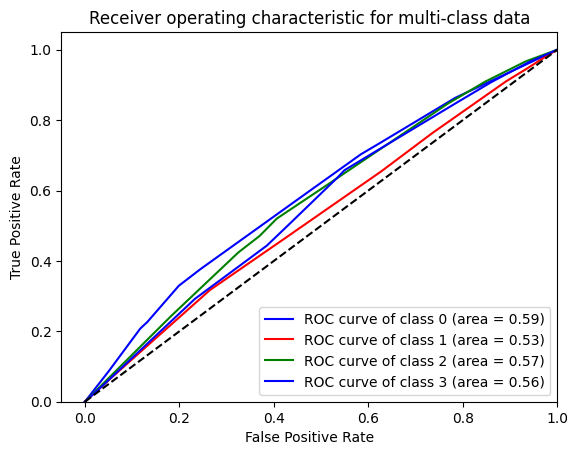

LogisticRegression on Training  data 
0.42684289810000486
[[    0  8580     0     0]
 [    0 17568     0     0]
 [    0 10825     0     0]
 [    0  4185     0     0]]
Recall 0.42684289810000486
F1-Score 0.42684289810000486
Preicsion 0.42684289810000486


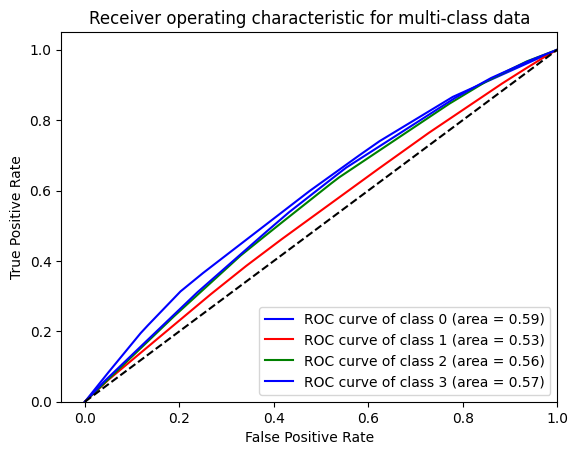

In [54]:
# diclare the logistic model
model = LogisticRegression(random_state=41)
# train the model on the data
model.fit(X_train, age_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
y_test_bin = label_binarize(age_test, classes=[0, 1, 2,3])
n_classes = y_test_bin.shape[1]
print("LogisticRegression on Test data ")
print(accuracy_score(age_test, y_pred))
# Plot and print confusion matrix
cnf_matrix = confusion_matrix(age_test, y_pred)
print(cnf_matrix)
print('Recall',recall_score(age_test, y_pred,average='micro'))
print('F1-Score',f1_score(age_test, y_pred,average='micro'))
print('Preicsion',precision_score(age_test, y_pred,average='micro'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()



print("LogisticRegression on Training  data ")
y_pred = model.predict(X_train)
y_score = model.predict_proba(X_train)
y_train_bin = label_binarize(age_train, classes=[0, 1, 2,3])
n_classes = y_test_bin.shape[1]
print(accuracy_score(age_train, y_pred))
# Plot and print confusion matrix
cnf_matrix = confusion_matrix(age_train, y_pred)
print(cnf_matrix)
print('Recall',recall_score(age_train, y_pred ,average='micro'))
print('F1-Score',f1_score(age_train, y_pred,average='micro'))
print('Preicsion',precision_score(age_train, y_pred,average='micro'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBClassifier on Test Dataset
(10280, 4)
(10280, 4)


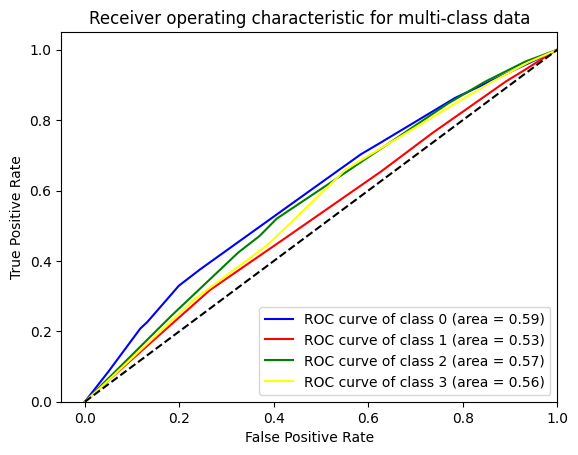

XGBClassifier on Train Dataset


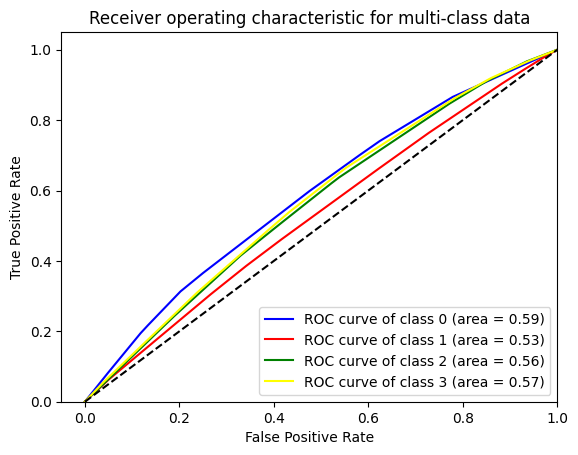

In [58]:
x_cfl=XGBClassifier(verbosity=0)
n_folds = 5
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
random_cfl=RandomizedSearchCV(x_cfl,prams,verbose=1,n_jobs=-1,return_train_score=True,scoring=LogLoss)
random_cfl.fit(X_train,age_train)
print("XGBClassifier on Test Dataset")
y_score = random_cfl.predict_proba(X_test)
print(y_score.shape)
y_test_bin = label_binarize(age_test, classes=[0,1,2,3])
print(y_test_bin.shape)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()



print("XGBClassifier on Train Dataset")
y_score = random_cfl.predict_proba(X_train)
y_train_bin = label_binarize(age_train, classes=[0, 1, 2,3])
n_classes = y_train_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [59]:
final_fit = random_cfl.best_estimator_.fit(X_train, age_train)

In [60]:
import pickle
pickle.dump(final_fit, open('model_age_without_event.pkl', 'wb'))
